In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from thefuzz import process, fuzz
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.data_processing import normalise_product_name

In [4]:
sns.set_theme(style="whitegrid")
PROCESSED_DATA_PATH = "C:/Project/UK store analysis/data/02_processed/canonical_products_e5.parquet"
df_canonical = pd.read_parquet(PROCESSED_DATA_PATH)

print("Canonical product data loaded successfully.")

Canonical product data loaded successfully.


In [5]:
df_canonical.sample(10)

,supermarket,prices,prices_unit,unit,names,date,category,own_brand,normalized_name,canonical_name
4262906,Morrisons,4.0,500.00,l,Rimmel London 60 Seconds Supers…,2024-02-04,health_products,False,rimmel london 60 seconds supers,rimmel london 60 seconds super shin
1696482,ASDA,3.5,1.75,unit,ASDA LED Candle 40W Large Screw Lightbulb,2024-02-26,household,True,led candle 40w large screw lightbulb,led candle 40w edison screw
3950987,Morrisons,3.5,23.30,kg,Thorntons Classic Egg,2024-02-18,food_cupboard,False,thorntons classic egg,thorntons classic easter egg
765041,ASDA,2.5,5.00,kg,Kellogg's All-Bran Breakfast Cereal,2024-04-03,food_cupboard,False,kelloggs allbran breakfast cereal,kelloggs allbran breakfast cereal
8223141,Tesco,3.5,3.50,unit,Tesco Aura Pasta Bowl Midnight,2024-03-06,home,True,aura pasta bowl midnight,aura pasta bowl midnight
8494614,Tesco,4.5,4.50,l,Coca-Cola Original Taste 4x250ml,2024-02-23,drinks,False,cocacola original taste 4x250ml,cocacola original taste 4x250ml
7160615,Sains,4.0,4.00,unit,Collection Incredibrow Define & Plus 2 Brunette,2024-01-14,free-from,False,collection incredibrow define plus 2 brunette,collection incredibrow define plus 2 brunette
8283732,Tesco,1.5,0.75,unit,Keep It Handy Cotton Comfort Insoles 2 Pairs,2024-03-03,household,False,keep it handy cotton comfort insoles 2 pairs,keep it handy cotton comfort insoles 2 pairs
714929,ASDA,2.5,5.00,l,Pledge Everyday Clean Multi-Surface Cleaner Su...,2024-04-04,household,False,pledge everyday clean multisurface cleaner sun...,pledge everyday clean multi surface classic ae...
4840873,Sains,3.5,3.50,unit,Baby Bio Original,2024-04-09,home,False,baby bio original,baby bio


# Time Series Decomposition

In [11]:
def load_and_validate_data(file_path):
    """Load and validate the dataset."""
    try:
        df = pd.read_parquet(file_path)
        print(f"✓ Data loaded successfully. Shape: {df.shape}")

        required_columns = ['canonical_name', 'supermarket', 'date', 'prices']
        missing_cols = [col for col in required_columns if col not in df.columns]
        if missing_cols:
            raise ValueError(f"Missing required columns: {missing_cols}")

        if not pd.api.types.is_datetime64_any_dtype(df['date']):
            df['date'] = pd.to_datetime(df['date'])

        return df
    except Exception as e:
        print(f"✗ Error loading data: {e}")
        return None


In [12]:
def explore_products(df, supermarket=None):
    """Print available supermarkets or products in a supermarket"""
    print("\n" + "="*40)
    print("DATASET EXPLORATION")
    print("="*40)

    if supermarket:
        products = df[df["supermarket"] == supermarket]["canonical_name"].unique()
        print(f"Available products at {supermarket} (showing up to 10):")
        for i, p in enumerate(sorted(products)[:10], 1):
            print(f"{i}. {p}")
        if len(products) > 10:
            print(f"... abd {len(products) - 10} more products")
    else:
        print("Available supermarkets")
        print(sorted(df["supermarket"].unique()))
        print(f"Total unique products: {df["canonical_name"].nunique()}")

In [13]:
def prepare_time_series(df, product_name, supermarket_name, min_obs=30):
    """Prepare daily time series for product prices"""
    print(f"\n{"="*40}")
    print(f"PREPARING TIME SERIES: {product_name} @ {supermarket_name}")
    print(f"{"="*40}")

    filtered = df[(df["canonical_name"] == product_name) & (df["supermarket"] == supermarket_name)]
    if filtered.empty:
        print(f"X No data for '{product_name}' at {supermarket_name}")
        return None
    
    filtered = filtered.sort_values('date')
    print(f"Found {len(filtered)} records from {filtered['date'].min().date()} to {filtered['date'].max().date()}")

    # Aggregate prices by date (mean if multiple)
    daily = filtered.groupby('date')['prices'].mean()
    
    # Reindex to full daily date range and interpolate missing
    full_idx = pd.date_range(start=daily.index.min(), end=daily.index.max(), freq='D')
    daily = daily.reindex(full_idx).interpolate(method='linear', limit_direction='both')

    missing = daily.isna().sum()
    if missing > 0:
        print(f"{missing} missing values interpolated")

    if len(daily) < min_obs:
        print(f"Not enough data: {len(daily)} observations (minimum {min_obs})")
        return None

    print(f"Prepared daily time series with {len(daily)} points")
    return daily


In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

def check_stationarity(ts, name="Time Series"):
    """Perform and print Augmented Dickey-Fuller test."""
    result = adfuller(ts.dropna())
    print(f"\n{name} Stationarity Test:")
    print(f"ADF Statistic: {result[0]:.6f}")
    print(f"p-value: {result[1]:.6f}")
    if result[1] <= 0.05:
        print("Series is stationary")
    else:
        print("Series may not be stationary")


In [18]:
def plot_seasonal_decomposition(ts, product, supermarket, period=7):
    """Perform and plot seasonal decomposition."""
    print(f"\n{'='*40}")
    print("SEASONAL DECOMPOSITION")
    print(f"{'='*40}")

    try:
        decomposition = seasonal_decompose(ts, model='additive', period=period, extrapolate_trend='freq')
        check_stationarity(ts, "Original Series")

        fig, axs = plt.subplots(4, 1, figsize=(15, 12))
        fig.suptitle(f"Seasonal Decomposition: {product} at {supermarket}", fontsize=16, fontweight='bold', y=0.98)

        axs[0].plot(decomposition.observed, color='blue')
        axs[0].set_title('Original')
        axs[0].axhline(decomposition.observed.mean(), color='red', linestyle='--')
        axs[0].fill_between(decomposition.observed.index, 
                            decomposition.observed.mean() - decomposition.observed.std(), 
                            decomposition.observed.mean() + decomposition.observed.std(), color='red', alpha=0.2)

        axs[1].plot(decomposition.trend, color='orange')
        axs[1].set_title('Trend')

        axs[2].plot(decomposition.seasonal, color='green')
        axs[2].set_title('Seasonal')

        axs[3].plot(decomposition.resid, color='purple')
        axs[3].axhline(0, color='black', alpha=0.3)
        axs[3].set_title('Residual')

        for ax in axs:
            ax.grid(True)
            ax.tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.subplots_adjust(top=0.93)
        plt.show()

        total_var = decomposition.observed.var()
        print("Variance explained:")
        print(f"Trend: {(decomposition.trend.var() / total_var) * 100:.1f}%")
        print(f"Seasonal: {(decomposition.seasonal.var() / total_var) * 100:.1f}%")
        print(f"Residual: {(decomposition.resid.var() / total_var) * 100:.1f}%")

        return decomposition
    except Exception as e:
        print(f"✗ Error in decomposition: {e}")
        return None


✓ Data loaded successfully. Shape: (9529242, 10)

DATASET EXPLORATION
Available products at Tesco (showing up to 10):
1. 0 fat greek style yogurt
2. 0 fat greek style yogurt 4x100g
3. 0 fat natural yogurt
4. 1 marigold extra life gloves kitchen large
5. 1 marigold extra life gloves kitchen medium
6. 10 balloons age 10
7. 10 battered crispy sushi rolls
8. 10 beechwood smoked cheese slices
9. 10 beef stock cubes
10. 10 british mixed weight caged eggs
... abd 23542 more products

PREPARING TIME SERIES: heinz tomato ketchup bottle @ Tesco
Found 179 records from 2024-01-09 to 2024-04-13
Prepared daily time series with 96 points

SEASONAL DECOMPOSITION

Original Series Stationarity Test:
ADF Statistic: -8.557840
p-value: 0.000000
Series is stationary


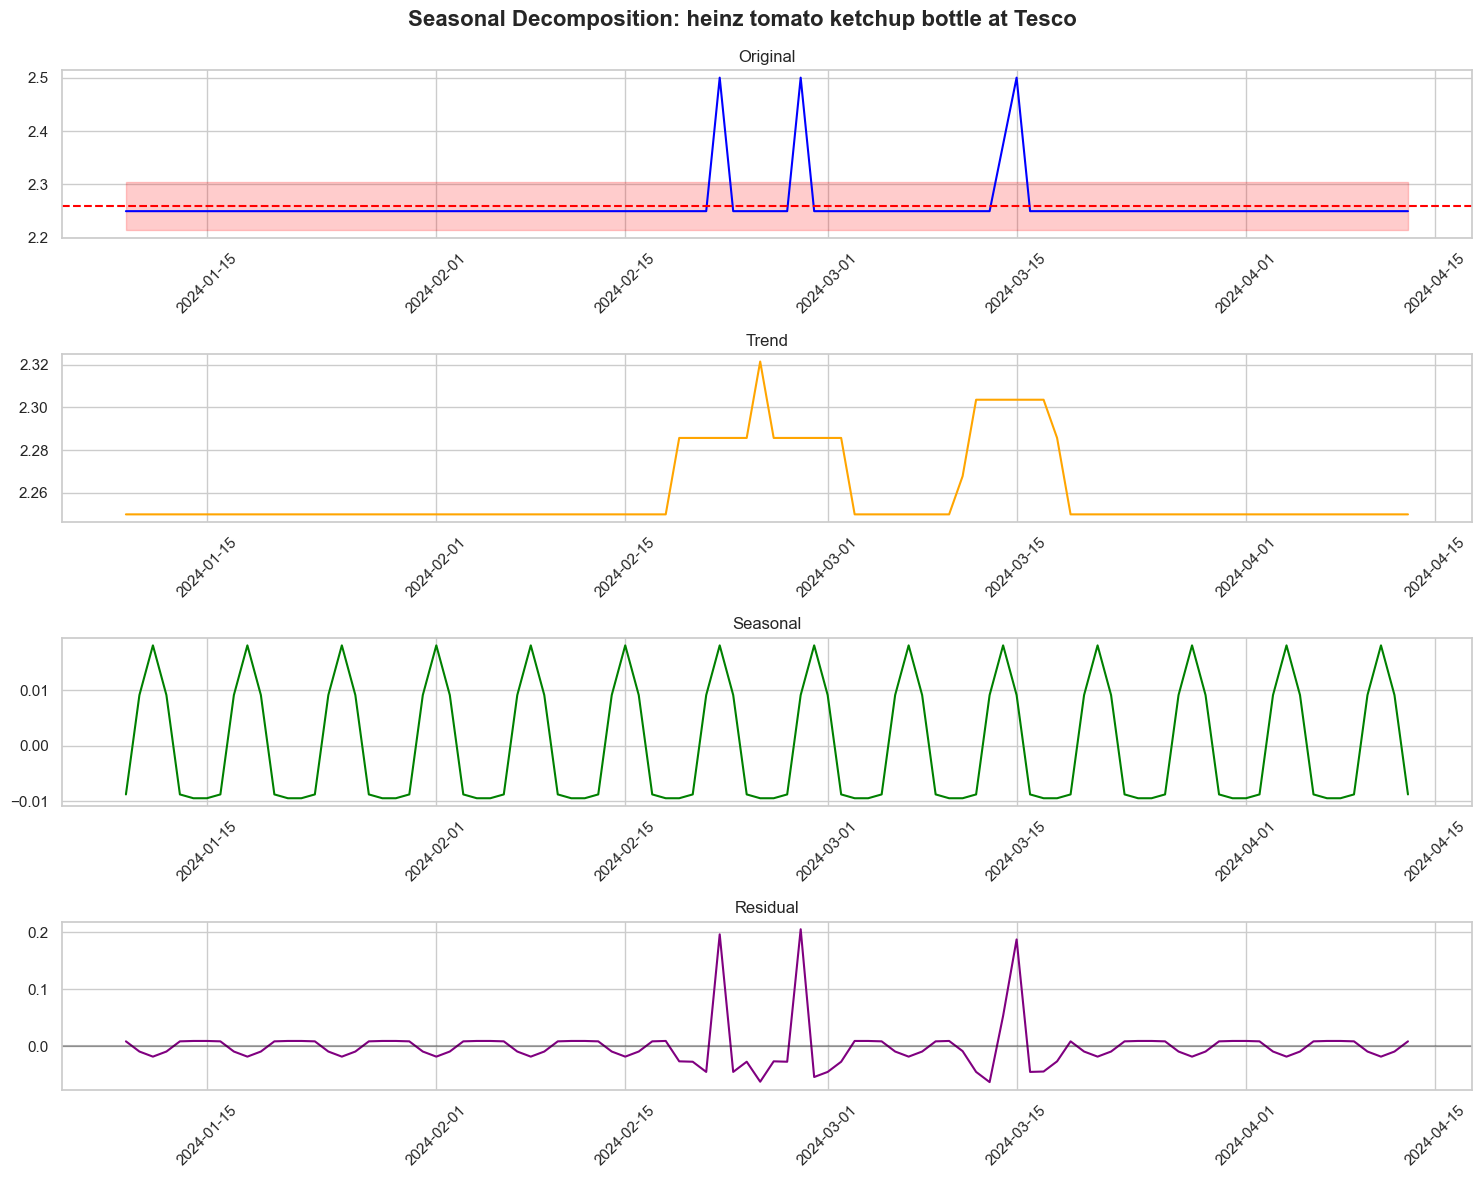

Variance explained:
Trend: 16.0%
Seasonal: 5.8%
Residual: 79.5%


In [19]:
# Set your params here
data_path = "C:/Project/UK store analysis/data/02_processed/canonical_products_e5.parquet"
product_name = "heinz tomato ketchup bottle"
supermarket_name = "Tesco"

# Load data
df = load_and_validate_data(data_path)

# Explore dataset
if df is not None:
    explore_products(df, supermarket_name)

# Prepare time series
if df is not None:
    ts_daily = prepare_time_series(df, product_name, supermarket_name)

# Decompose and plot
if ts_daily is not None:
    decomposition = plot_seasonal_decomposition(ts_daily, product_name, supermarket_name)
